# Imbalanced datasets
------------------------------------

This example shows the different approaches we can take to handle imbalanced datasets.

The data used is a variation on the Australian weather dataset from [https://www.kaggle.com/jsphyg/weather-dataset-rattle-package](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package). The goal of this dataset is to predict whether or not it will rain tomorrow training a binay classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

<Figure size 432x288 with 0 Axes>

In [2]:
# Load data
X = pd.read_csv('./datasets/weatherAUS.csv')

# Let's have a look at a subset of the data
X.sample(frac=1).iloc[:5, :8]

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed
56886,Bendigo,10.3,14.0,12.4,1.2,NaN,ENE,30.0
132891,AliceSprings,21.0,39.1,1.2,9.0,12.2,NNW,41.0
100511,Nuriootpa,2.6,15.7,1.0,1.0,5.3,ENE,15.0
10385,CoffsHarbour,19.9,27.0,0.0,4.8,3.0,NNW,35.0
112606,PearceRAAF,12.5,36.1,0.0,NaN,13.3,WSW,46.0


## Run the pipeline

In [3]:
# Initialize ATOM with the created dataset
atom = ATOMClassifier(X, n_rows=0.3, test_size=0.3, verbose=2, random_state=1)
atom.clean()
atom.impute()
atom.encode()

<< ================== ATOM ================== >>
Algorithm task: binary classification.

Dataset stats ================== >>
Shape: (42658, 22)
Missing values: 95216
Categorical columns: 5
Scaled: False
-----------------------------------
Train set size: 29861
Test set size: 12797
-----------------------------------
Train set balance: No:Yes <==> 3.5:1.0
Test set balance: No:Yes <==> 3.4:1.0
-----------------------------------
Distribution of classes:
|     |   dataset |   train |   test |
|:----|----------:|--------:|-------:|
| No  |     33139 |   23247 |   9892 |
| Yes |      9519 |    6614 |   2905 |

Applying data cleaning...
 --> Label-encoding the target column.
Fitting Imputer...
Imputing missing values...
 --> Dropping 352 rows for containing less than 50% non-missing values.
 --> Dropping 92 rows due to missing values in feature MinTemp.
 --> Dropping 56 rows due to missing values in feature MaxTemp.
 --> Dropping 350 rows due to missing values in feature Rainfall.
 --> Dropp

In [4]:
# First, we fit a logistic regression model directly on the imbalanced data
atom.run("LR", metric="f1", bagging=5)


Training ===================================== >>
Models: LR
Metric: f1


Results for Logistic Regression:         
Fit ---------------------------------------------
Train evaluation --> f1: 0.6174
Test evaluation --> f1: 0.6096
Time elapsed: 0.074s
Bagging -----------------------------------------
Evaluation --> f1: 0.6078 ± 0.0048
Time elapsed: 0.321s
-------------------------------------------------
Total time: 0.396s


Final results ========================= >>
Duration: 0.397s
------------------------------------------
Logistic Regression --> f1: 0.608 ± 0.005


## Class weights

In [5]:
# Add class weights through the est_params parameter
atom.run("LR_cw", est_params={"class_weight": atom.get_class_weight()}, bagging=5)


Training ===================================== >>
Models: LR_cw
Metric: f1


Results for Logistic Regression:         
Fit ---------------------------------------------
Train evaluation --> f1: 0.6449
Test evaluation --> f1: 0.6472
Time elapsed: 0.074s
Bagging -----------------------------------------
Evaluation --> f1: 0.6483 ± 0.0014
Time elapsed: 0.306s
-------------------------------------------------
Total time: 0.381s


Final results ========================= >>
Duration: 0.382s
------------------------------------------
Logistic Regression --> f1: 0.648 ± 0.001


## Oversampling & undersampling

In [6]:
# Create a new branch for oversampling
atom.branch = "oversampling"

New branch 'oversampling' successfully created!


In [7]:
# Perform oversampling of the minority class
atom.balance(strategy='smote', sampling_strategy=0.9)

Oversampling with SMOTE...
 --> Adding 5830 rows to class: Yes.


In [8]:
atom.classes  # Note the balanced training set!

,dataset,train,test
0,13189,9317,3872
1,9536,8385,1151


In [9]:
atom.run("LR_os", bagging=5)


Training ===================================== >>
Models: LR_os
Metric: f1


Results for Logistic Regression:         
Fit ---------------------------------------------
Train evaluation --> f1: 0.7918
Test evaluation --> f1: 0.6505
Time elapsed: 0.097s
Bagging -----------------------------------------
Evaluation --> f1: 0.6489 ± 0.0031
Time elapsed: 0.368s
-------------------------------------------------
Total time: 0.465s


Final results ========================= >>
Duration: 0.466s
------------------------------------------
Logistic Regression --> f1: 0.649 ± 0.003


In [10]:
# Create the undersampling branch from main
atom.branch = "undersampling_from_main"

# Note that here the data is still imbalanced!
atom.classes

New branch 'undersampling' successfully created!


,dataset,train,test
0,13189,9317,3872
1,3706,2555,1151


In [11]:
# Perform undersampling of the majority class
atom.balance(strategy='NearMiss', sampling_strategy=0.9)

Undersampling with NearMiss...
 --> Removing 6479 rows from class: No.


In [12]:
atom.run("LR_us", bagging=5)


Training ===================================== >>
Models: LR_us
Metric: f1


Results for Logistic Regression:         
Fit ---------------------------------------------
Train evaluation --> f1: 0.7829
Test evaluation --> f1: 0.6061
Time elapsed: 0.052s
Bagging -----------------------------------------
Evaluation --> f1: 0.6037 ± 0.0071
Time elapsed: 0.213s
-------------------------------------------------
Total time: 0.266s


Final results ========================= >>
Duration: 0.267s
------------------------------------------
Logistic Regression --> f1: 0.604 ± 0.007 ~


## Analyze results

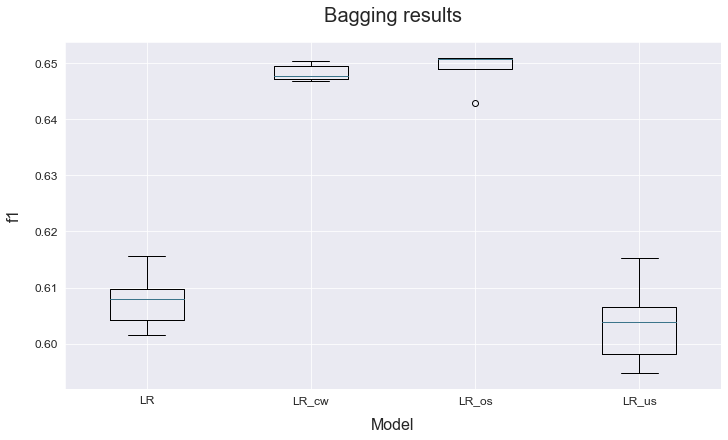

In [13]:
atom.plot_bagging()